# Evolution of cooperation

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 12

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [65]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

from copy import copy

import numpy as np
from numpy.random import rand, randint, permutation

from thinkstats2 import RandomSeed

import thinkplot

In [180]:
class Agent:
    
    keys = [(None, None),
            (None, 'C'),
            (None, 'D'),
            ('C', 'C'),
            ('C', 'D'),
            ('D', 'C'),
            ('D', 'D')]
    
    def __init__(self, values):
        self.responses = dict(zip(self.keys, values))
        
    def copy(self):
        return Agent(self.responses.values())

    def reset(self):
        self.hist = [None, None]
        self.score = 0
        
    def last_two_responses(self):
        return tuple(self.hist[-2:])
    
    def respond(self, other):
        key = other.last_two_responses()
        resp = self.responses[key]
        return resp
        
    def append(self, resp, pay):
        self.hist.append(resp)
        self.score += pay

In [181]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

In [182]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None, None): 'D',
 (None, 'C'): 'D',
 (None, 'D'): 'D',
 ('C', 'C'): 'D',
 ('C', 'D'): 'D',
 ('D', 'C'): 'D',
 ('D', 'D'): 'D'}

In [183]:
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

In [184]:
class Tournament:
    num_rounds = 20
        
    payoffs = {('C', 'C'): (3, 3),
              ('C', 'D'): (0, 5),
              ('D', 'C'): (5, 0),
              ('D', 'D'): (1, 1)}
    
    def play(self, agent1, agent2):
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
            #print(resp1, resp2, pay1, pay2)
            
        return agent1.score, agent2.score
        
    def melee(self, agents):
        
        n = len(agents)
        i_row = np.arange(n)
        np.random.shuffle(i_row)
        j_row = (i_row + 1) % n
        totals = np.zeros(n)
        
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
        
        for i in i_row:
            agents[i].fitness = totals[i]

In [185]:
tour = Tournament()
tour.play(all_d, tft)

(24, 19)

In [186]:
agents = [all_c, all_d, tft]
agents

In [187]:
tour.melee(agents)

In [188]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [236]:
from scipy.stats import zscore

def prob_surv(scores):
    zs = zscore(scores)
    zs = np.where(np.isnan(zs), 4, zs)
    return logistic(zs, A=0.5, B=2, K=0.9)

In [237]:
scores = np.linspace(0, 100)
scores

array([   0.   ,    2.041,    4.082,    6.122,    8.163,   10.204,
         12.245,   14.286,   16.327,   18.367,   20.408,   22.449,
         24.49 ,   26.531,   28.571,   30.612,   32.653,   34.694,
         36.735,   38.776,   40.816,   42.857,   44.898,   46.939,
         48.98 ,   51.02 ,   53.061,   55.102,   57.143,   59.184,
         61.224,   63.265,   65.306,   67.347,   69.388,   71.429,
         73.469,   75.51 ,   77.551,   79.592,   81.633,   83.673,
         85.714,   87.755,   89.796,   91.837,   93.878,   95.918,
         97.959,  100.   ])

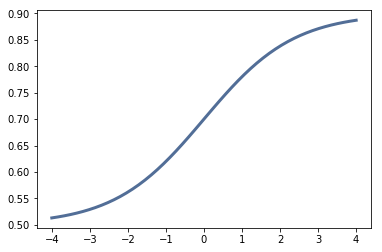

In [238]:
probs = prob_surv(scores)
thinkplot.plot(zscores, probs)

In [275]:
class Simulation:
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=100):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        fits = self.get_fitnesses()
        ps = prob_surv(fits)
        
        # see who dies
        index_dead = self.choose_dead(ps)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, fits):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        fits: array of fitnesses
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [290]:
def make_random_agents(n):
    agents = []
    for _ in range(n):
        values = np.random.choice(['C', 'D'], size=7)
        agent = Agent(values)
        agents.append(agent)
    return agents

agents = make_random_agents(100)

In [291]:
tour = Tournament()
sim = Simulation(tour, agents)

In [292]:
sim.run()

In [293]:
for agent in sim.agents:
    print(agent.responses.values())

dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'D', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D', 'C', 'C', 'C', 'C', 'D'])
dict_values(['C', 'D

In [270]:
tft.responses.values()

dict_values(['C', 'C', 'D', 'C', 'D', 'C', 'D'])